In [1]:
from SFS.src.py.utils import *
from numpy.fft import fft2, fft, ifft, fftfreq, fftshift, ifftshift, rfftfreq, rfft2
from IPython.display import HTML

In [2]:
def get_K(field, con):
    r, u = con["r"], con["u"]
    return - ( r + u * field**2 ) * field

def get_qw(param, mask=False):
    T, N, M, L, TIME = param
    q = (fftfreq(N, L / (2 * np.pi * N)))
    w = (fftfreq(M, TIME / (2 * np.pi * M)))
    q, w = np.meshgrid(q, w) 
    q, w = fftshift(q), fftshift(w)
    if mask:
        mask = q==0
        w = np.ma.array(w, mask=mask)
        q = np.ma.array(q, mask=mask)
    return q, w

In [3]:
def get_corr(seed, folder, start=0):
    run_folder = folder + "{m}/".format(m = seed)
    X, d, N, L, T, dt, con = get_para(run_folder)

    fn = "varphi"
    field = get_field(run_folder, fn)
    samples = len(field)
    M = samples - start
    times = get_time(run_folder)[start:]
    field = field[start:]
    TIME = times[-1] - times[0]

    param = T, N, M, L, TIME

    q, w = get_qw(param)

    # win = np.hanning(M) # hanning window
    win = np.ones(M)

    field = field * win[:, None]

    phiqw = fft2(field) * (L/N) * (TIME/M)
    phiqw = fftshift(phiqw)

    Cqw = phiqw * np.conj(phiqw) / L / TIME

    K = get_K(field, con)
    Kqw = fft2(K) * (L/N) * (TIME/M)
    Kqw = fftshift(Kqw) - q**2 * phiqw

    Xqw = 1 / (2*T) * (phiqw * np.conj(- 1j * w * phiqw - Kqw ) ) / L / TIME

    mask = Cqw < 1e-20

    w = np.ma.array(w, mask=mask)
    q = np.ma.array(q, mask=mask)
    Cqw = np.ma.array(Cqw, mask=mask)
    Xqw = np.ma.array(Xqw, mask=mask)
    
    return (q, w), Cqw, Xqw, con, param

In [4]:
def get_CX(num, folder):
    (q, w), C, X, con, param = get_corr(1, folder)
    count = 1

    for i in range(1, num):
        Ci, Xi = get_corr(i+1, folder)[1:3]
        C += Ci
        X += Xi
        count += 1
        
    C = C / count
    X = X / count

    if np.max(np.abs(np.imag(C))) < 1e-10: C = np.real(C)
    return (q, w), C, X, con, param

In [5]:
number = 3
folder = "data/SETD_paper/{n}/".format(n=number)

num = count_files(folder)
print(num)

1024


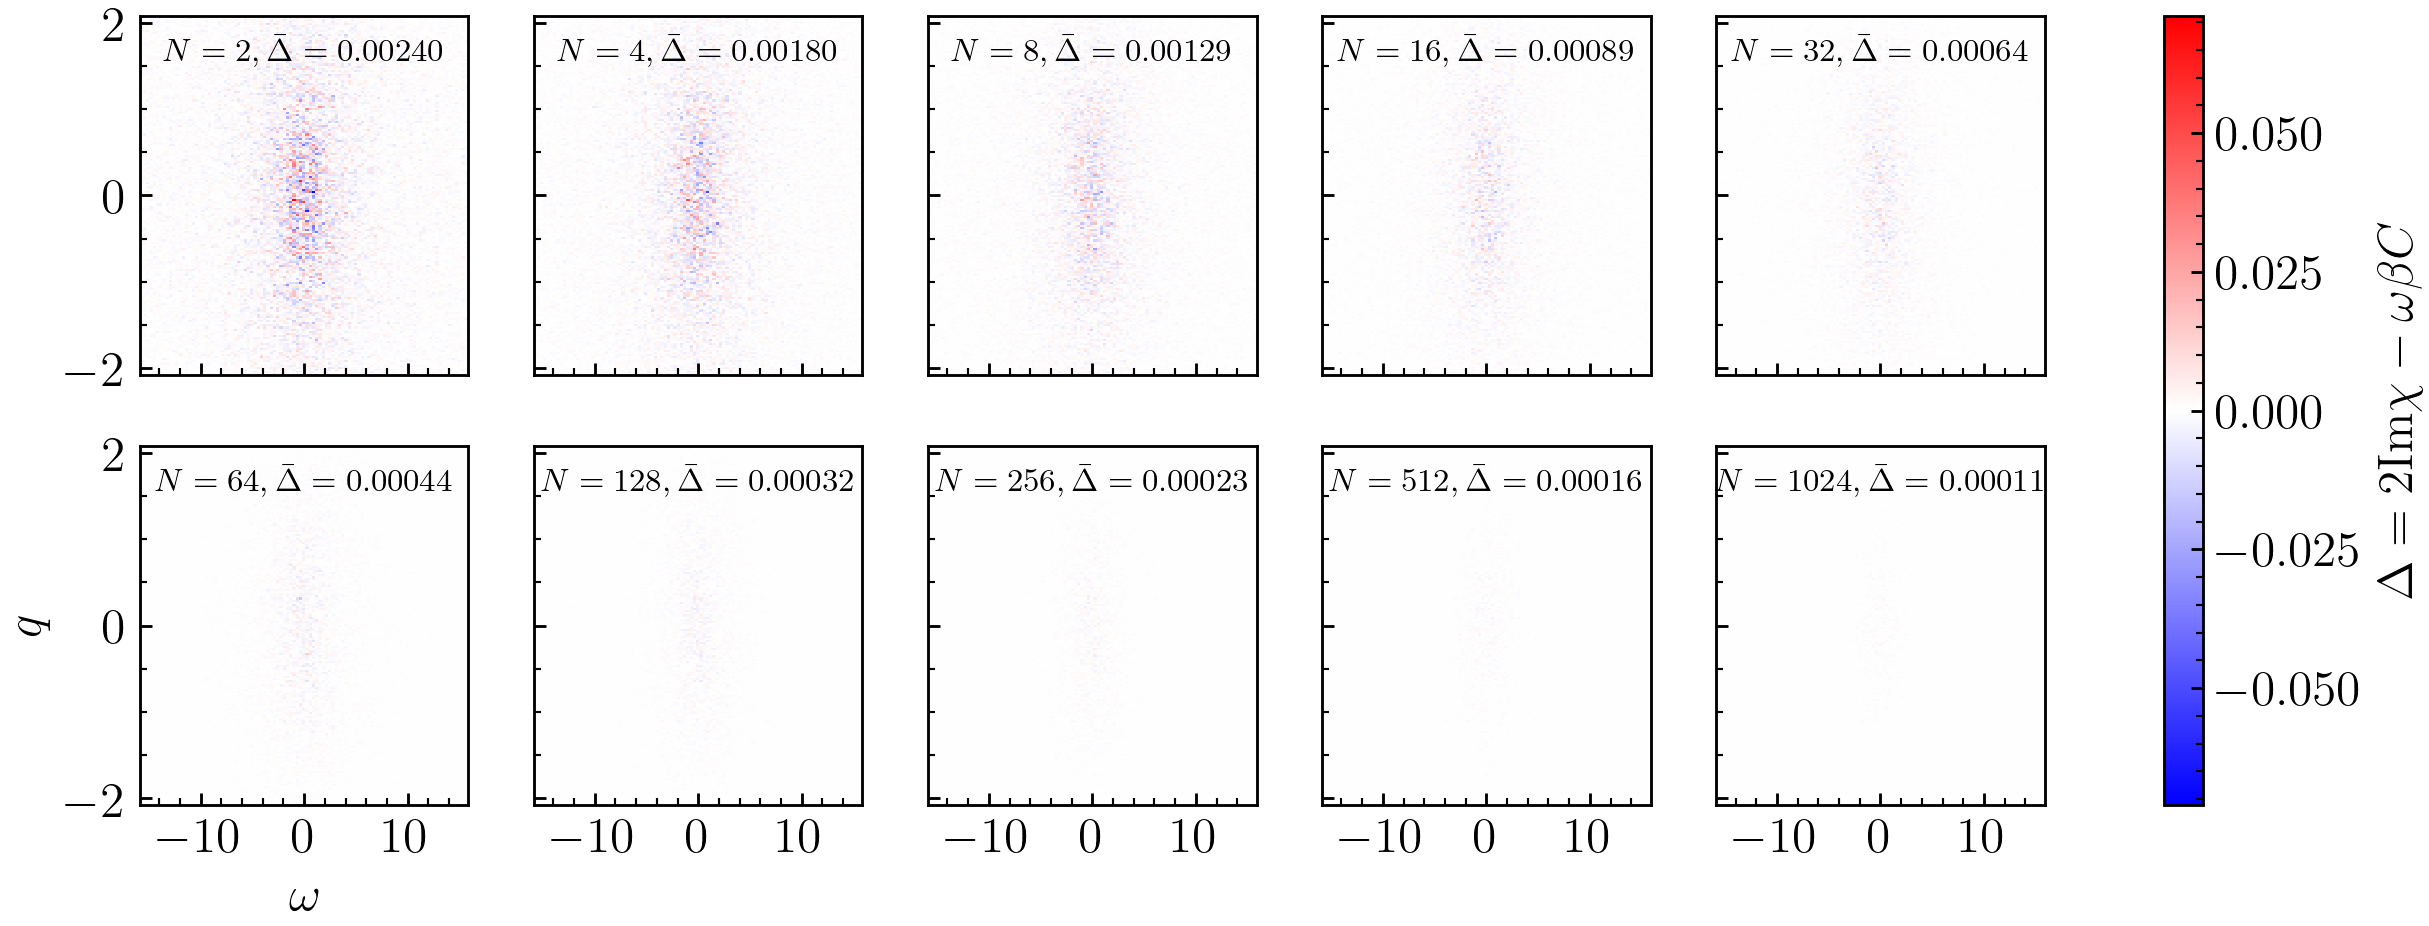

In [6]:
NN = int(np.log2(num))
rows = 2
errs = []
errs2 = []
nums = [2**n for n in range(1,NN+1,1)]
fig, ax = plt.subplots(rows, (len(nums)-1)//rows+1, figsize=(12, 4), sharey=True, sharex=True)
ax = np.atleast_2d(ax)
axf = ax.flatten()

for i, num in enumerate(nums):
    (q, w), Ci, Xi, con, param = get_CX(num, folder)
    T, N, M, L, TIME = param 

    DFDT = (2 * np.imag(Xi))- (w * Ci / T)

    err = np.mean(np.abs(DFDT))
    errs.append(err)

    if i == 0: lim = np.max(np.abs(DFDT))
    p = axf[i].pcolor(w, q, DFDT, cmap=cm.bwr, norm=colors.Normalize(-lim, lim))
    axf[i].set_title("$N={num}, \\bar \\Delta={err:.5f}$".format(num=num, err=err), y=.82, fontsize=9)

    err2 = np.mean(DFDT)
    errs2.append(err2)

ax[-1,0].set_xlabel("$\\omega$")
ax[-1,0].set_ylabel("$q$")

cbar = fig.colorbar(p, label="$\\Delta = 2 \\mathrm{Im} \\chi - \\omega \\beta  C$", ax=ax)
[t.set_fontsize(14) for t in cbar.ax.get_yticklabels()]


plt.show()

$N=1024, r=1.0, u=1, T=0.1$


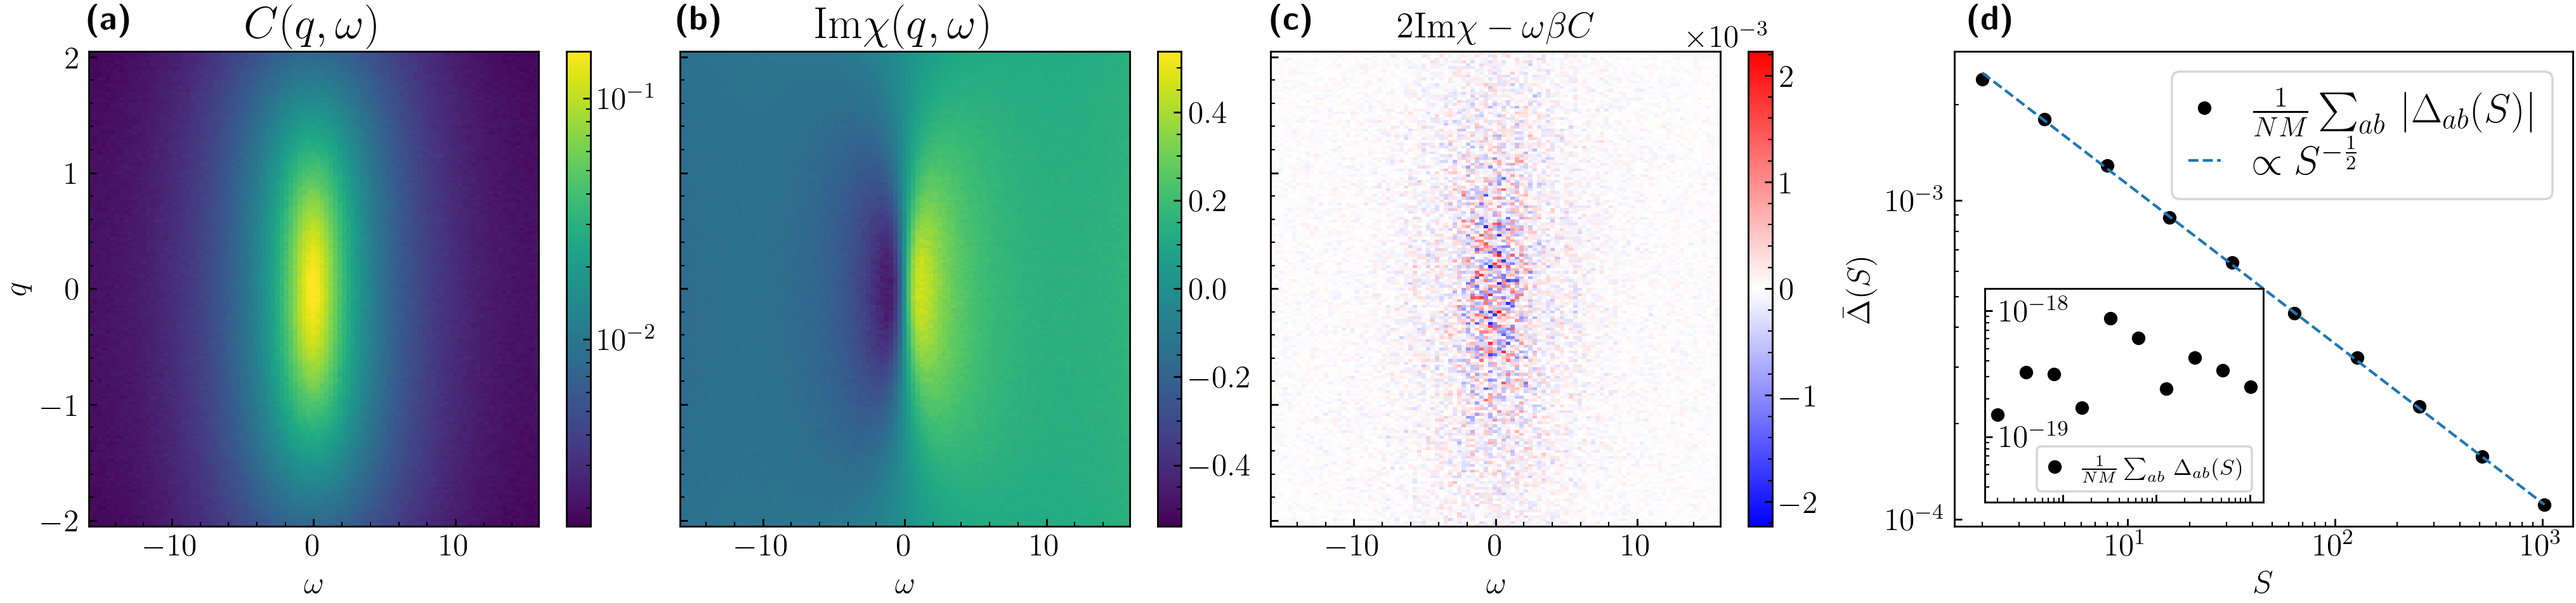

In [7]:
C, X = Ci, Xi
qlim=2.05
size = 19

# Setup figure/axis

fig = plt.figure(figsize=(size, size*0.2))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1.1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2], sharey=ax0)
ax3 = fig.add_subplot(gs[0, 3])
ax = [ax0, ax1, ax2, ax3]

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.setp(ax[2].get_yticklabels(), visible=False)


# Plot 1

p = ax[0].pcolor(w, q, C, norm=colors.LogNorm(np.min(C), np.max(C)))
ax[0].set_xlabel("$\\omega$")
ax[0].set_ylabel("$q$")
ax[0].set_title("$C(q,\\omega)$", fontsize=20)
ax[0].set_ylim(-qlim, qlim)
fig.colorbar(p, ax=ax[0])

# Plot 2

ImX = np.imag(X)
lim = np.max(np.abs(ImX)) * 1.14
p = ax[1].pcolor(w, q, ImX, vmin=-lim, vmax=lim)
ax[1].set_xlabel("$\\omega$")
ax[1].set_title("$\\mathrm{Im} \\chi(q,\\omega)$", fontsize=20)
fig.colorbar(p, ax=ax[1])

# Plot 3

DFDT = (2 * ImX)-(w * C / T)
lim = np.max(np.abs(DFDT))
p = ax[2].pcolor(w, q, DFDT, cmap=cm.bwr, norm=colors.Normalize(-lim, lim))
ax[2].set_xlabel("$\\omega$")
ax[2].set_title("$2 \\mathrm{Im} \\chi - \\omega \\beta  C$", fontsize=16)
cbar = fig.colorbar(p, ax=ax[2]) 
cbar.formatter.set_powerlimits((0,0)) 

# Fix heatmaps

for axis in ax: 
    for coll in axis.collections: 
        coll.set_edgecolor('face')

# Plot 3

nums = np.array(nums) * 1.
ax[3].loglog(nums, errs, 'ko', label="$\\frac{1 }{N M} \\sum_{ab} \\, |\\Delta_{ab}(S)|$")
ax[3].loglog(nums, (nums/nums[-1])**(-1/2)*errs[-1], '--', label='$\\propto S^{-\\frac{1}{2}}$')
ax[3].set_xlabel("$S$")
ax[3].set_ylabel("$ \\bar \\Delta(S)$")
ax[3].set_yticklabels([], minor=True)
ax[3].legend(fontsize=18)


# Inset 

inset_ax = ax[3].inset_axes([0.05,0.05,0.45,0.45])
inset_ax.loglog(nums, np.abs(errs2), 'ko', label="$ \\frac{1 }{N M} \\sum_{ab} \\, \\Delta_{ab}(S)$")
inset_ax.set_ylim(3e-20, 1.5e-18)
inset_ax.set_xticklabels([])
inset_ax.yaxis.set_tick_params(direction='in', which='both', pad=-38)
inset_ax.tick_params(direction='in', which="both")
inset_ax.legend(fontsize=10, loc="lower right")


# Label, adjustments


fig.subplots_adjust(wspace=0.05)
pos2 = ax[2].get_position()
pos3 = ax[3].get_position()
shift = 0.03
ax[3].set_position([pos3.x0 + shift, pos3.y0, pos3.width, pos3.height])
label(ax, x = 0.1, y=1.1)
fig.savefig("fig/FDT.pdf", dpi=120)

T, N, M, L, TIME = param
title = "$N={num}, r={r}, u={u}, T={T}$".format(num=num,r=con["r"], u=con["u"], T=T)
print(title)